<a href="https://colab.research.google.com/github/jiachengpan/goldenspoon/blob/master/neverland_goldenspoon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!rm -rf goldenspoon cached
!git clone https://github.com/jiachengpan/goldenspoon.git

Cloning into 'goldenspoon'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 75 (delta 24), reused 52 (delta 10), pack-reused 0
Unpacking objects: 100% (75/75), done.


In [8]:
import os
import sys
sys.path.append('goldenspoon')
import goldenspoon

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

mpl_font_path = os.path.join(os.path.dirname(mpl.matplotlib_fname()), 'fonts/ttf')
!wget -q -O $mpl_font_path/simhei.ttf "https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf"


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.serif'] = ['SimHei']

sns.set_style("darkgrid", {"font.sans-serif": ['simhei', 'Arial']})

mpl.font_manager._rebuild()
zhfont = mpl.font_manager.FontProperties(fname = f'{mpl_font_path}/simhei.ttf')

In [10]:
db = goldenspoon.Database('goldenspoon/data')

loading goldenspoon/data/funds.total_value_incr_ratio.xls
loading goldenspoon/data/funds.total_value_and_stock_investment.xls
loading goldenspoon/data/stocks.topn_funds_holding.xls
loading goldenspoon/data/stocks.monthly_performance_2021.xls
loading goldenspoon/data/funds.topn_stock_mkt_value.xls
loading goldenspoon/data/stocks.basic_info.xls
loading goldenspoon/data/stocks.general.xls
loading goldenspoon/data/funds.basic_info.xls
loading goldenspoon/data/funds.topn_stock_name.xls
loading goldenspoon/data/funds.topn_stock_share_ratio.xls
loading goldenspoon/data/stocks.monthly_performance_2020.xls
loading goldenspoon/data/stocks.margin_and_short_diff.xls
loading goldenspoon/data/stocks.quarterly_report.xls
WARN: column "持股基金家数 [股本类型]流通股本" value already assigned: key: ('688087.SH', datetime.date(2021, 6, 30)), value: 92.0 vs 91.0


# indicators


In [26]:
import pandas as pd
import re
import datetime

class Indicator:
  def __init__(self, db):
    self.db = db

  k_column_date = '日期'

  k_stock_column_name           = '股票名称'
  k_stock_column_code           = '股票代码'
  k_stock_column_industry       = '所属中证行业(2016) [行业类别]{level}级'
  k_stock_column_type           = '股票风格分类'
  k_stock_column_total_value    = '区间日均总市值 [起始交易日期]截止日3月前 [单位]亿元'
  k_stock_column_avg_price      = '当月成交均价 [复权方式]不复权'
  k_stock_column_close_price    = '月收盘价 [复权方式]不复权'
  k_stock_column_turnover_rate  = '月换手率 [单位]%'
  k_stock_column_amplitutde     = '月振幅 [单位]%'
  k_stock_column_margin_diff    = '融资融券差额 [单位]元'
  k_stock_column_share_ratio_of_funds   = '基金持股比例 [单位]% [比例类型]占流通股比例'
  k_stock_column_share_number_of_funds  = '基金持股数量 [单位]股'
  k_stock_column_num_of_funds           = '持股基金家数 [股本类型]流通股本'

  def get_stocks(self):
    '''
    return: pd.DataFrame with columns: [股票名称, 股票代码]
    '''
    return self.db.get_stocks()[[self.k_stock_column_name, self.k_stock_column_code]].dropna()
  
  def get_stocks_map(self):
    '''
    return: dict: 股票代码 -> 股票名称
    '''
    return self.db.stock_map

  def get_stocks_name_map(self):
    '''
    return: dict: 股票名称 -> 股票代码
    '''
    return self.db.stock_map_reverse

  def add_stock_name(self, df):
    if self.k_stock_column_code in df:
      df[self.k_stock_column_name] = df[self.k_stock_column_code].map(self.get_stocks_map())
    elif self.k_stock_column_name in df:
      df[self.k_stock_column_code] = df[self.k_stock_column_name].map(self.get_stocks_name_map())
    else:
      assert 0, 'invalid df columns: {}'.format(df.columns.tolist())

    columns =  [self.k_column_date, self.k_stock_column_code, self.k_stock_column_name]
    columns += [col for col in df.columns if col not in columns]
    return df[[col for col in columns if col in df.columns]]

  def get_stock_general(self):
    '''
    return: pd.DataFrame with columns: [股票名称, 股票代码, 所属行业(四级), 类型]
    '''
    untimed_columns =  [self.k_stock_column_name, self.k_stock_column_code]
    untimed_columns += [self.k_stock_column_industry.format(level=i) for i in [1,2,3,4]]
    timed_columns   =  [self.k_column_date,
                        self.k_stock_column_code, 
                        self.k_stock_column_type]

    stocks_untimed = self.db.get_stocks()[untimed_columns]
    stocks_timed   = self.db.get_stock_stats('date')[timed_columns].dropna() \
                      .sort_values(self.k_column_date, ascending=False) \
                      .groupby([self.k_column_date, self.k_stock_column_code]) \
                      .last()
    return pd.merge(stocks_untimed, stocks_timed, on=self.k_stock_column_code).dropna()

  def get_stock_performance(self):
    columns = [self.k_column_date,
               self.k_stock_column_code,
               self.k_stock_column_total_value,
               self.k_stock_column_close_price,
               self.k_stock_column_avg_price,
               self.k_stock_column_turnover_rate,
               self.k_stock_column_amplitutde,
               self.k_stock_column_margin_diff,
               ]
    stocks_timed = self.db.get_stock_stats('date')[columns].dropna()
    return self.add_stock_name(stocks_timed).dropna()

  def get_stock_holding_funds_share(self):
    columns = [self.k_column_date,
               self.k_stock_column_code,
               self.k_stock_column_share_ratio_of_funds,
               self.k_stock_column_share_number_of_funds,
               self.k_stock_column_num_of_funds,
               ]
    return self.add_stock_name(self.db.get_stock_stats('date')[columns].dropna()).dropna()

  def get_stock_holding_funds_number(self):
    columns = [self.k_column_date,
               self.k_stock_column_code,
               self.k_stock_column_num_of_funds,
               ]

    return self.add_stock_name(self.db.get_stock_stats('date')[columns].dropna()).dropna()

  def get_stock_topn_holding_funds(self):
    fund_topn_stocks = self.db.get_fund_stats('topn_stocks')
    fund_topn_stocks_share_ratio = fund_topn_stocks[fund_topn_stocks['indicator'] == '重仓股持仓占流通股比例'] \
                                    .groupby([self.k_column_date, self.k_stock_column_name])[self.k_fund_column_code] \
                                    .apply(set) \
                                    .reset_index()
    return self.add_stock_name(fund_topn_stocks_share_ratio.dropna()).dropna()
  

  k_fund_column_name  = '基金名称'
  k_fund_column_code  = '基金代码'
  k_fund_column_owner = '基金管理人简称'
  k_fund_column_type  = '投资类型(二级分类)'
  k_fund_column_total_value = '基金资产总值 [单位]元'
  k_fund_column_net_value   = '基金资产净值 [单位]元'
  k_fund_column_net_value_inc_rate  = '报告期净值增长率 [报告期净值数据项]过去3个月 [单位]%'
  #k_fund_column_income      = ''
  k_fund_column_manager             = '基金经理'
  k_fund_column_manager_longest     = '任职期限最长的现任基金经理 [名次]第1名'
  k_fund_column_manager_history     = '基金经理(历任)'

  def get_funds(self):
    return self.db.get_funds()[[self.k_fund_column_name, self.k_fund_column_code]].dropna()

  def get_funds_map(self):
    return self.db.fund_map

  def get_funds_name_map(self):
    return self.db.fund_map_reverse

  def get_funds_general(self):
    untimed_columns = [self.k_fund_column_name, 
                       self.k_fund_column_code, 
                       self.k_fund_column_owner,
                       self.k_fund_column_type,
                       ]
    timed_columns   = [self.k_column_date,
                       self.k_fund_column_code,
                       self.k_fund_column_total_value,
                       ]
    
    funds_untimed = self.db.get_funds()[untimed_columns]
    funds_timed   = self.db.get_fund_stats('date')[timed_columns].dropna() \
                      .sort_values(self.k_column_date, ascending=False) \
                      .groupby([self.k_column_date, self.k_fund_column_code]) \
                      .last().reset_index()

    return pd.merge(funds_untimed, funds_timed, on=self.k_fund_column_code).dropna()

  def get_funds_manager(self):
    columns = [self.k_fund_column_code,
               self.k_fund_column_manager_history,
               ]
    re_manager = re.compile(r'(.+)\((\d.*)\)')
    date_fmt   = '%Y%m%d'

    result = []
    for fund_code, fund_managers in self.db.get_funds()[columns].values.tolist():
      for manager_str in fund_managers.split(','):
        m = re_manager.match(manager_str)
        assert m, 'invalid manager: {}'.format(manager_str)
        manager_name, manager_time = m.groups()

        if '-' in manager_time:
          start_time, end_time = manager_time.split('-')
          start_time = datetime.datetime.strptime(start_time, date_fmt)
          end_time   = datetime.datetime.strptime(end_time, date_fmt)
          current    = False
        elif '至今' in manager_time:
          start_time = datetime.datetime.strptime(manager_time[:8], date_fmt)
          end_time   = datetime.datetime.today()
          current    = True
        else:
          assert 0, 'invalid time {}'.format(manager_time)

        result.append({
            self.k_fund_column_code: fund_code,
            self.k_fund_column_manager: manager_name,
            'start': start_time,
            'end': end_time,
            'current': current,
        })

    return pd.DataFrame(result)

  def get_funds_manager_stats(self, only_current=True):
    df = self.get_funds_manager()

    if only_current:
      df = df[df['current'] == True]

    stats = df \
            .groupby(self.k_fund_column_manager)[self.k_fund_column_code] \
            .apply(set).reset_index()
    stats['基金名称'] = stats[self.k_fund_column_code].apply(lambda v: set([self.db.get_fund_by_code(vv) for vv in v]))
    stats['基金数量'] = stats[self.k_fund_column_code].apply(lambda v: len(v))

    return stats

  def get_funds_topn_stocks(self):
    fund_topn_stocks = self.db.get_fund_stats('topn_stocks')
    key_columns = [self.k_column_date,
                   self.k_fund_column_code, 
                   self.k_stock_column_name,
                   'indicator']
    fund_topn_stocks = fund_topn_stocks.groupby(key_columns).sum().reset_index()
    return fund_topn_stocks.pivot(index=[self.k_column_date,
                                         self.k_fund_column_code, 
                                         self.k_stock_column_name], 
                                  columns=['indicator'], 
                                  values=['value'])

In [27]:
ind = Indicator(db)

In [29]:
ind.get_funds_general()

,基金名称,基金代码,基金管理人简称,投资类型(二级分类),日期,基金资产总值 [单位]元
0,融通新区域新经济灵活配置混合,001152.OF,融通基金,灵活配置型基金,2017-03-31,1.070679e+09
1,融通新区域新经济灵活配置混合,001152.OF,融通基金,灵活配置型基金,2017-06-30,9.992851e+08
2,融通新区域新经济灵活配置混合,001152.OF,融通基金,灵活配置型基金,2017-09-30,9.587891e+08
3,融通新区域新经济灵活配置混合,001152.OF,融通基金,灵活配置型基金,2017-12-31,8.557922e+08
4,融通新区域新经济灵活配置混合,001152.OF,融通基金,灵活配置型基金,2018-03-31,7.772274e+08
...,...,...,...,...,...,...
123691,太平洋证券六个月滚动持有债券,980003.OF,太平洋,长期纯债型基金,2020-06-30,1.856550e+08
123692,太平洋证券六个月滚动持有债券,980003.OF,太平洋,长期纯债型基金,2020-09-30,1.856161e+08
123693,太平洋证券六个月滚动持有债券,980003.OF,太平洋,长期纯债型基金,2020-12-31,1.235115e+08
123694,太平洋证券六个月滚动持有债券,980003.OF,太平洋,长期纯债型基金,2021-03-31,1.529985e+08


# raw data

In [ ]:
db.get_funds().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12554 entries, 0 to 12553
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   基金代码                                    12554 non-null  object 
 1   基金名称                                    12554 non-null  object 
 2   任职基金数 [名次]第1名 [单位]只                     12551 non-null  float64
 3   任职天数 [名次]第1名 [单位]天                      12532 non-null  float64
 4   任职年化回报 [名次]第1名 [单位]%                    7959 non-null   float64
 5   任职期限最长的现任基金经理 [名次]第1名                   12551 non-null  object 
 6   几何平均年化收益率 [名次]第1名 [收益率计算方法]普通收益率 [单位]%  12209 non-null  float64
 7   同类基金数量 [基金分类]二级分类 [单位]只                 12554 non-null  float64
 8   基金管理人简称                                 12554 non-null  object 
 9   基金经理(历任)                                12554 non-null  object 
 10  投资策略                                    12547 non-null  ob

In [ ]:
db.get_fund_stats('date').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125290 entries, 0 to 125289
Data columns (total 6 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   基金代码                            125290 non-null  object 
 1   基金资产净值 [单位]元                    124260 non-null  float64
 2   基金资产总值 [单位]元                    123696 non-null  float64
 3   报告期净值增长率 [报告期净值数据项]过去3个月 [单位]%  119672 non-null  float64
 4   日期                              125290 non-null  object 
 5   股票投资市值 [单位]元                    84725 non-null   float64
dtypes: float64(4), object(2)
memory usage: 5.7+ MB


In [ ]:
db.get_fund_stats('topn_stocks')

,indicator,value,基金代码,日期,股票名称
0,重仓股股票市值,2.580000e+08,000001.OF,2017-03-31,五粮液
1,重仓股持仓占流通股比例,1.580713e-01,000001.OF,2017-03-31,五粮液
2,重仓股股票市值,2.277526e+08,000001.OF,2017-03-31,中国医药
3,重仓股持仓占流通股比例,9.518687e-01,000001.OF,2017-03-31,中国医药
4,重仓股股票市值,2.100000e+08,000001.OF,2017-03-31,神雾环保
...,...,...,...,...,...
1587998,重仓股持仓占流通股比例,8.871600e-04,970021.OF,2021-06-30,新城控股
1587999,重仓股股票市值,5.856000e+05,970021.OF,2021-06-30,中国神华
1588000,重仓股持仓占流通股比例,1.819200e-04,970021.OF,2021-06-30,中国神华
1588001,重仓股股票市值,4.816000e+05,970021.OF,2021-06-30,保利地产


In [ ]:
db.get_stocks().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4473 entries, 0 to 4472
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   股票代码                      4473 non-null   object
 1   股票名称                      4473 non-null   object
 2   所属中信行业(2020) [行业类别]1级     4457 non-null   object
 3   所属中证行业(2016) [行业类别]1级     4469 non-null   object
 4   所属中证行业(2016) [行业类别]2级     4469 non-null   object
 5   所属中证行业(2016) [行业类别]3级     4469 non-null   object
 6   所属中证行业(2016) [行业类别]4级     4469 non-null   object
 7   所属国民经济行业 [行业级别]门类行业       4455 non-null   object
 8   所属申万行业(2021) [行业类别]1级     4457 non-null   object
 9   所属证监会行业(新) [行业级别]门类行业     4457 non-null   object
 10  是否属于重要指数成份 [所属指数]中小板指     4469 non-null   object
 11  是否属于重要指数成份 [所属指数]创业板指     4469 non-null   object
 12  是否属于重要指数成份 [所属指数]沪深300指数  4469 non-null   object
dtypes: object(13)
memory usage: 454.4+ KB


In [ ]:
db.get_stock_stats('date')

,股票代码,区间日均总市值 [起始交易日期]截止日3月前 [单位]亿元,基金持股数量 [单位]股,基金持股比例 [单位]% [比例类型]占流通股比例,"市盈率(PE,TTM)",当月成交均价 [复权方式]不复权,所属概念板块,持股基金家数 [股本类型]流通股本,日期,月振幅 [单位]%,月换手率 [单位]%,月收盘价 [复权方式]不复权,流通股本 [单位]股,股票规模指标,股票风格分类,自由流通市值 [单位]元,融资融券差额 [单位]亿元,融资融券差额 [单位]元
0,000001.SZ,NaN,NaN,NaN,NaN,21.168020,NaN,NaN,2021-01-29,29.6794,14.3901,23.09,NaN,NaN,NaN,NaN,6.165212,NaN
1,000001.SZ,NaN,NaN,NaN,NaN,23.493580,NaN,NaN,2021-02-26,17.7566,11.5598,21.38,NaN,NaN,NaN,NaN,12.848179,NaN
2,000001.SZ,NaN,NaN,NaN,NaN,21.467065,NaN,NaN,2021-03-30,15.0140,12.0587,22.01,NaN,NaN,NaN,NaN,7.969600,NaN
3,000001.SZ,NaN,NaN,NaN,NaN,21.891867,NaN,NaN,2021-04-30,20.0818,7.3354,23.29,NaN,NaN,NaN,NaN,5.446338,NaN
4,000001.SZ,NaN,NaN,NaN,NaN,23.785044,NaN,NaN,2021-05-31,10.9918,5.2318,24.20,NaN,NaN,NaN,NaN,4.133413,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131284,603999.SH,NaN,252602.0,0.043855,NaN,NaN,NaN,8.0,2019-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131285,603999.SH,NaN,86102.0,0.014948,NaN,NaN,NaN,6.0,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131286,688081.SH,NaN,5553657.0,NaN,NaN,NaN,NaN,6.0,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131287,688181.SH,NaN,7019380.0,NaN,NaN,NaN,NaN,7.0,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Stock Indicators

In [ ]:
ind = Indicator(db)

ind_stocks_general = ind.get_stock_general()
ind_stocks_perf    = ind.get_stock_performance()
ind_stocks_holding_funds_share_ratio = ind.get_stock_holding_funds_share_ratio()
ind_stocks_holding_funds_number = ind.get_stock_holding_funds_number()
ind_stocks_holding_topn_funds = ind.get_stock_topn_holding_funds()

AttributeError: ignored

In [ ]:
ind_stocks_general.shape

In [ ]:
ind_stocks_perf.head(10)

In [ ]:
ind_stocks_holding_funds_share_ratio

In [ ]:
ind_stocks_holding_funds_number

In [ ]:
ind_stocks_holding_topn_funds

## Fund Indicators

In [ ]:
ind = Indicator(db)
ind.get_funds_topn_stocks()

In [ ]:
ind = Indicator(db)
ind.get_funds_general()

In [ ]:
funds = ind.db.get_funds()
funds.info()

In [ ]:
funds.head()

In [ ]:
fund_stats = ind.db.get_fund_stats('date')
fund_stats.info()

# Analysis

In [ ]:
def calibrate_stock_share_held_by_funds(ind):
  join_columns = [Indicator.k_column_date, Indicator.k_stock_column_name]

  ind_stocks_perf                = ind.get_stock_performance()
  ind_stocks_share_held_by_funds = ind.get_stock_holding_funds_share()
  ind_funds_topn_stocks          = ind.get_funds_topn_stocks()
  ind_funds_topn_stocks.columns  = [name for _, name in ind_funds_topn_stocks.columns]

  funds_topn_stocks = ind_funds_topn_stocks.reset_index()

  stocks_total_held_by_funds = funds_topn_stocks.groupby(join_columns).sum().reset_index()
  stocks_share_held_by_funds_and_price = ind_stocks_share_held_by_funds.merge(ind_stocks_perf, on=join_columns)

  result_columns = [Indicator.k_column_date, 
                    Indicator.k_stock_column_name,
                    Indicator.k_stock_column_share_ratio_of_funds,
                    Indicator.k_stock_column_share_number_of_funds,
                    Indicator.k_stock_column_avg_price,
                    Indicator.k_stock_column_num_of_funds,
                    '重仓股持仓占流通股比例',
                    '重仓股股票市值',
                    ]  

  result = pd.merge(
      stocks_share_held_by_funds_and_price,
      stocks_total_held_by_funds, 
      on=join_columns)
  #[result_columns]
  
  result['重仓股股票市值 computed']  = result[Indicator.k_stock_column_share_number_of_funds] * result[Indicator.k_stock_column_avg_price]
  result['重仓股股票市值 computed2'] = result['重仓股持仓占流通股比例'] * result[Indicator.k_stock_column_total_value]

  return result

In [ ]:
ind = Indicator(db)
calibrated_stock_share_held_by_funds = calibrate_stock_share_held_by_funds(ind)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20179 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32929 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_a

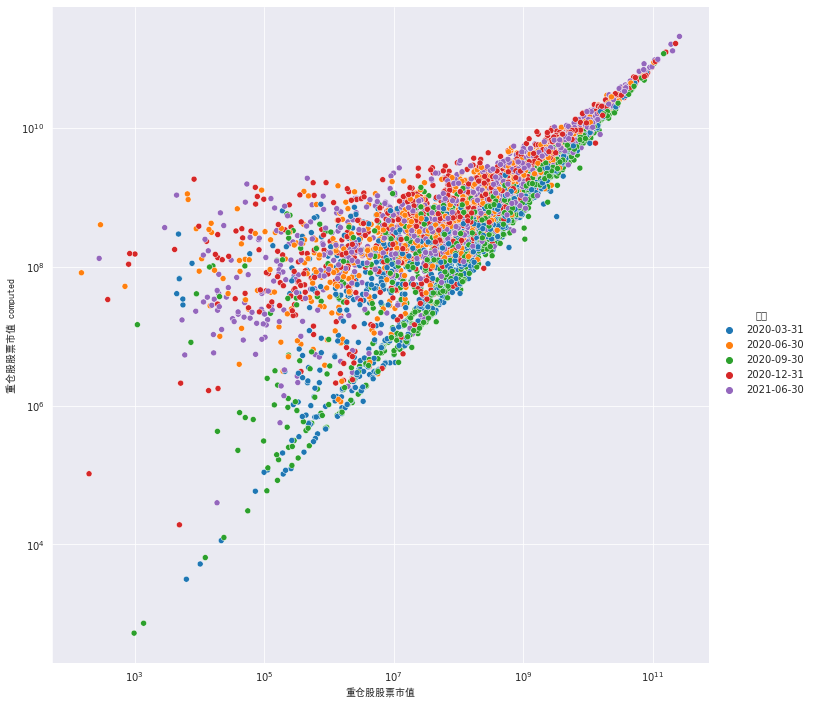

In [ ]:
# 比较：
# * 重仓股股票市值 - 基金数据中top10重仓股市值
# * 重仓股股票市值 computed - 股票数据中重仓基金的股票市值

# 可以看到，股票数据中重仓基金的股票市值 普遍高于 基金数据中top10重仓股市值
# * 和 top10 相关？
# * 和季报相关？

g = sns.relplot(x='重仓股股票市值', 
                y='重仓股股票市值 computed',
                hue=Indicator.k_column_date,
                data=calibrated_stock_share_held_by_funds,
                height=10)
g.ax.set_xscale('log')
g.ax.set_yscale('log')
g.set_axis_labels('重仓股股票市值', '重仓股股票市值 computed', fontproperties=zhfont)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37325 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20179 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32929 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31080 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20540 missing from current font.
  font.set_

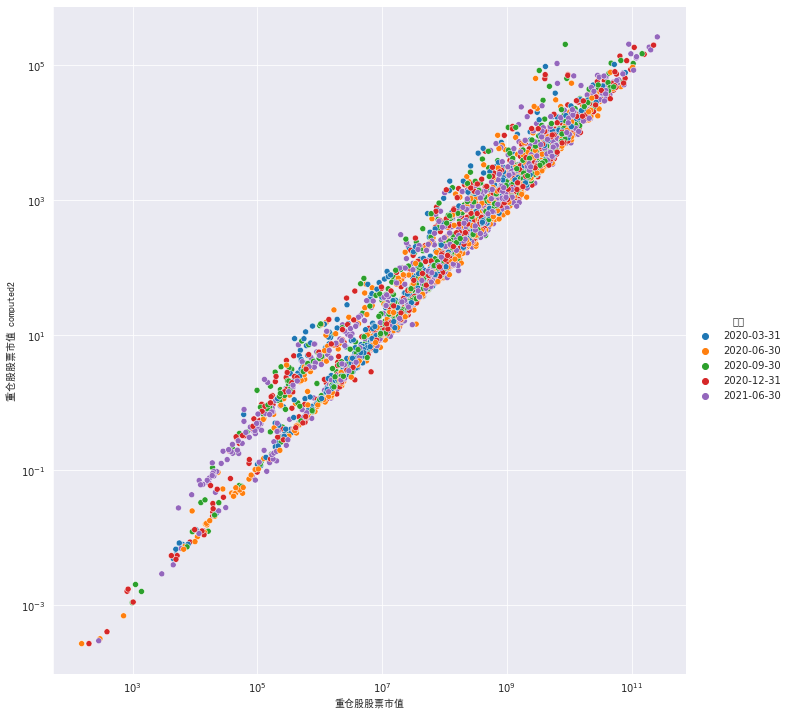

In [ ]:
g = sns.relplot(x='重仓股股票市值', 
                y='重仓股股票市值 computed2',
                hue=Indicator.k_column_date,
                data=calibrated_stock_share_held_by_funds,
                height=10)
g.ax.set_xscale('log')
g.ax.set_yscale('log')
g.set_axis_labels('重仓股股票市值', '重仓股股票市值 computed2', fontproperties=zhfont)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22522 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37329 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32929 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20363 missing from current font.
  font.set_

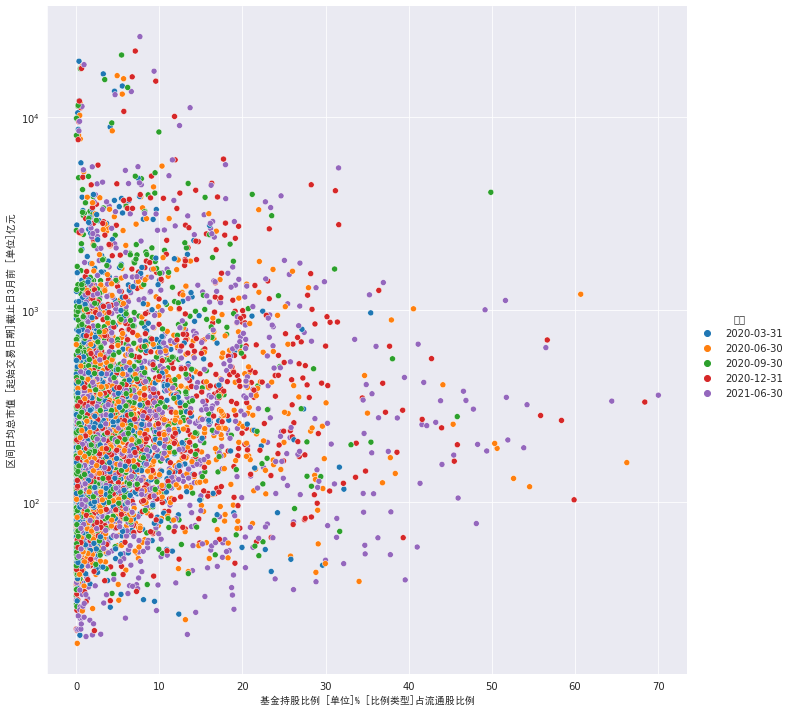

In [ ]:
g = sns.relplot(x=Indicator.k_stock_column_share_ratio_of_funds, 
                y=Indicator.k_stock_column_total_value,
                hue=Indicator.k_column_date,
                data=calibrated_stock_share_held_by_funds,
                height=10)
#g.ax.set_xscale('log')
g.ax.set_yscale('log')
g.set_axis_labels(Indicator.k_stock_column_share_ratio_of_funds, 
                  Indicator.k_stock_column_total_value, 
                  fontproperties=zhfont)

In [ ]:
calibrated_stock_share_held_by_funds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4995 entries, 0 to 4994
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   日期                             4995 non-null   object 
 1   股票代码_x                         4995 non-null   object 
 2   股票名称                           4995 non-null   object 
 3   基金持股比例 [单位]% [比例类型]占流通股比例      4995 non-null   float64
 4   基金持股数量 [单位]股                   4995 non-null   float64
 5   持股基金家数 [股本类型]流通股本              4995 non-null   float64
 6   股票代码_y                         4995 non-null   object 
 7   区间日均总市值 [起始交易日期]截止日3月前 [单位]亿元  4995 non-null   float64
 8   月收盘价 [复权方式]不复权                 4995 non-null   float64
 9   当月成交均价 [复权方式]不复权               4995 non-null   float64
 10  月换手率 [单位]%                     4995 non-null   float64
 11  月振幅 [单位]%                      4995 non-null   float64
 12  融资融券差额 [单位]元                   4995 non-null   f

In [ ]:
ind_stocks_perf = ind.get_stock_performance()
ind_stocks_perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9085 entries, 8926 to 128530
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   日期                             9085 non-null   object 
 1   股票代码                           9085 non-null   object 
 2   股票名称                           9085 non-null   object 
 3   区间日均总市值 [起始交易日期]截止日3月前 [单位]亿元  9085 non-null   float64
 4   月收盘价 [复权方式]不复权                 9085 non-null   float64
 5   当月成交均价 [复权方式]不复权               9085 non-null   float64
 6   月换手率 [单位]%                     9085 non-null   float64
 7   月振幅 [单位]%                      9085 non-null   float64
 8   融资融券差额 [单位]元                   9085 non-null   float64
dtypes: float64(6), object(3)
memory usage: 709.8+ KB


In [ ]:
ind_funds_topn_stocks          = ind.get_funds_topn_stocks()
ind_funds_topn_stocks.columns  = [name for _, name in ind_funds_topn_stocks.columns]

In [ ]:
ind_funds_topn_stocks.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794377 entries, 0 to 794376
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   日期           794377 non-null  object 
 1   基金代码         794377 non-null  object 
 2   股票名称         794377 non-null  object 
 3   重仓股持仓占流通股比例  793999 non-null  float64
 4   重仓股股票市值      793617 non-null  float64
dtypes: float64(2), object(3)
memory usage: 30.3+ MB


In [ ]:
topn_stocks_visited_by_funds = ind_funds_topn_stocks.reset_index() \
                                .groupby([Indicator.k_fund_column_code, Indicator.k_stock_column_name]) \
                                .count()[Indicator.k_column_date]
                              

In [ ]:
topn_stocks_visited_by_funds.reset_index().columns = [Indicator.k_fund_column_code, ]

,基金代码,股票名称,日期
0,000001.OF,万润股份,2
1,000001.OF,万科A,2
2,000001.OF,三峡水利,1
3,000001.OF,上海钢联,5
4,000001.OF,东山精密,3
...,...,...,...
341607,970021.OF,安迪苏,1
341608,970021.OF,新亚强,1
341609,970021.OF,新城控股,1
341610,970021.OF,格力电器,1


In [ ]:
topn_stocks_visited_by_funds = pd.merge(topn_stocks_visited_by_funds.reset_index(), ind.get_stock_performance(),
                                        on=[Indicator.k_stock_column_name])

In [ ]:
topn_stocks_visited_by_funds

,基金代码,股票名称,日期_x,日期_y,股票代码,区间日均总市值 [起始交易日期]截止日3月前 [单位]亿元,月收盘价 [复权方式]不复权,当月成交均价 [复权方式]不复权,月换手率 [单位]%,月振幅 [单位]%,融资融券差额 [单位]元
0,000001.OF,万润股份,2,2020-03-31,002643.SZ,145.076088,12.67,15.529609,34.2230,40.7258,155476520.0
1,000001.OF,万润股份,2,2020-06-30,002643.SZ,135.955656,17.17,16.326500,47.5620,13.6037,207353212.0
2,000001.OF,万润股份,2,2020-09-30,002643.SZ,166.258754,18.12,18.501936,25.8136,13.8018,238953282.0
3,000001.OF,万润股份,2,2020-12-31,002643.SZ,174.273385,21.77,20.275096,29.7572,16.3994,249311291.0
4,000001.OF,万润股份,2,2021-06-30,002643.SZ,149.292871,17.78,16.449143,17.8931,16.4991,240738801.0
...,...,...,...,...,...,...,...,...,...,...,...
1429196,970008.OF,节能铁汉,1,2020-03-31,300197.SZ,69.932470,3.09,3.178286,78.8490,35.7414,260087942.0
1429197,970008.OF,节能铁汉,1,2020-06-30,300197.SZ,65.366447,2.54,2.575725,17.2580,9.9206,210465303.0
1429198,970008.OF,节能铁汉,1,2020-09-30,300197.SZ,76.435154,3.81,4.019895,179.6336,68.2692,277590479.0
1429199,970008.OF,节能铁汉,1,2020-12-31,300197.SZ,82.327113,3.17,3.204370,33.3840,19.8795,236952576.0


In [ ]:
g = sns.relplot(x=Indicator.k_stock_column_share_ratio_of_funds, 
                y=Indicator.k_stock_column_total_value,
                hue=Indicator.k_column_date,
                data=calibrated_stock_share_held_by_funds,
                height=10)
g.ax.set_xscale('log')
g.ax.set_yscale('log')
g.set_axis_labels(Indicator.k_stock_column_share_ratio_of_funds, 
                  Indicator.k_stock_column_total_value, 
                  fontproperties=zhfont)